In [1]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
df = pd.read_feather('../../dataset/preprocessed_data.feather')[['user_id', 'product_id', 'category_id', 'category_code', 'brand']]
df.head()

,user_id,product_id,category_id,category_code,brand
0,541312140,44600062,2103807459595387724,#unknown,shiseido
1,554748717,3900821,2053013552326770905,appliances.environment.water_heater,aqua
2,519107250,17200506,2053013559792632471,furniture.living_room.sofa,#unknown
3,550050854,1307067,2053013558920217191,computers.notebook,lenovo
4,535871217,1004237,2053013555631882655,electronics.smartphone,apple


In [3]:
total_rows = len(df)

train_size = int(total_rows * 0.9)

train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

print(f'train: {len(train_df)}, test: {len(test_df)}')

del df

train: 38203885, test: 4244877


In [4]:
user_counts = train_df['user_id'].value_counts().reset_index()[['user_id', 'count']]
unique_user_ids = user_counts[user_counts['count'] >= 10]['user_id']
user_id_to_index = {user_id: index for index, user_id in enumerate(unique_user_ids)}
user_index_to_id = {index: user_id for index, user_id in enumerate(unique_user_ids)}

product_counts = train_df['product_id'].value_counts().reset_index()[['product_id', 'count']]
unique_product_ids = product_counts[product_counts['count'] >= 5]['product_id']
product_id_to_index = {product_id: index for index, product_id in enumerate(unique_product_ids)}
product_index_to_id = {index: product_id for index, product_id in enumerate(unique_product_ids)}

del user_counts, product_counts

In [5]:
unique_brands = train_df['brand'].unique()
brand_id_to_index = {brand: index for index, brand in enumerate(unique_brands)}
brand_index_to_id = {index: brand for index, brand in enumerate(unique_brands)}

unique_category_ids = train_df['category_id'].unique()
category_id_to_index = {category_id: index for index, category_id in enumerate(unique_category_ids)}
category_index_to_id = {index: category_id for index, category_id in enumerate(unique_category_ids)}

In [6]:
train_df = train_df[
    (train_df['user_id'].isin(unique_user_ids)) & 
    (train_df['product_id'].isin(unique_product_ids)) &
    (train_df['brand'].isin(unique_brands)) &
    (train_df['category_id'].isin(unique_category_ids))
]

test_df = test_df[
    (test_df['user_id'].isin(unique_user_ids)) & 
    (test_df['product_id'].isin(unique_product_ids)) &
    (test_df['brand'].isin(unique_brands)) &
    (test_df['category_id'].isin(unique_category_ids))
]

train_df['user_index'] = [user_id_to_index[user_id] for user_id in train_df['user_id']]
train_df['product_index'] = [product_id_to_index[product_id] for product_id in train_df['product_id']]
train_df['brand_index'] = [brand_id_to_index[brand] for brand in train_df['brand']]
train_df['category_index'] = [category_id_to_index[category_id] for category_id in train_df['category_id']]

test_df['user_index'] = [user_id_to_index[user_id] for user_id in test_df['user_id']]
test_df['product_index'] = [product_id_to_index[product_id] for product_id in test_df['product_id']]
test_df['brand_index'] = [brand_id_to_index[brand] for brand in test_df['brand']]
test_df['category_index'] = [category_id_to_index[category_id] for category_id in test_df['category_id']]

print(f'unique user ids: {len(unique_user_ids)}')
print(f'unique product ids: {len(unique_product_ids)}')
print(f'unique brands: {len(unique_brands)}')
print(f'unique category ids: {len(unique_category_ids)}')
print(f'train: {len(train_df)}, test: {len(test_df)}')

train_df.head()

unique user ids: 890624
unique product ids: 130913
unique brands: 3299
unique category ids: 613
train: 32022554, test: 2253627


,user_id,product_id,category_id,category_code,brand,user_index,product_index,brand_index,category_index
0,541312140,44600062,2103807459595387724,#unknown,shiseido,32147,28939,0,0
2,519107250,17200506,2053013559792632471,furniture.living_room.sofa,#unknown,462789,5410,2,2
3,550050854,1307067,2053013558920217191,computers.notebook,lenovo,427246,213,3,3
4,535871217,1004237,2053013555631882655,electronics.smartphone,apple,84837,43,4,4
5,512742880,1480613,2053013561092866779,computers.desktop,pulser,140152,11240,5,5


In [7]:
class RecommendDataset(Dataset):
    def __init__(self, df):
        self.data = []
        for user, product, brand, category in df[['user_index', 'product_index', 'brand_index', 'category_index']].values:
            self.data.append([int(user), int(product), int(brand), int(category)])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = RecommendDataset(train_df)
test_dataset = RecommendDataset(test_df)

In [8]:
print(f'train:{len(train_dataset)}, test: {len(test_dataset)}')
print(train_dataset[0])
print(test_dataset[0])

train:32022554, test: 2253627
[32147, 28939, 0, 0]
[183080, 363, 53, 4]


In [9]:
# For negative sampling
user_index_to_viewed_product_indices = train_df.groupby('user_index')['product_index'].agg(set).to_dict()
product_index_to_brand_index = dict(zip(train_df['product_index'], train_df['brand_index']))
product_index_to_category_index = dict(zip(train_df['product_index'], train_df['category_index']))
total_product_indices = train_df['product_index'].unique().tolist()

In [10]:
def collate_fn(batch):
    users = []
    products = []
    brands = []
    categories = []

    neg_users = []
    neg_products = []
    neg_brands = []
    neg_categories = []
    
    for row in batch:
        user = row[0]
        product = row[1]
        brand = row[2]
        category = row[3]

        user_viewed_product_indices = user_index_to_viewed_product_indices.get(user, [])
        negative_product = None
        while True:
            negative_product = random.choice(total_product_indices)
            if negative_product not in user_viewed_product_indices:
                break

        negative_brand = product_index_to_brand_index[negative_product]
        negative_category = product_index_to_category_index[negative_product]

        users.append(user)
        products.append(product)
        brands.append(brand)
        categories.append(category)

        neg_users.append(user)
        neg_products.append(negative_product)
        neg_brands.append(negative_brand)
        neg_categories.append(negative_category)

    return {
        "positive": (
            torch.LongTensor(users),
            torch.LongTensor(products),
            torch.LongTensor(brands),
            torch.LongTensor(categories),
        ),
        "negative": (
            torch.LongTensor(neg_users),
            torch.LongTensor(neg_products),
            torch.LongTensor(neg_brands),
            torch.LongTensor(neg_categories),
        )
    }

In [11]:
batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f'train: {len(train_loader)}, test: {len(test_loader)}')

train: 7819, test: 551


In [12]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f'device: {device}')

device: mps


In [13]:
class UserTower(nn.Module):
    def __init__(self, num_users, embedding_dim, layers):
        super(UserTower, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(embedding_dim, layers[0]))
        for h_in, h_out in zip(layers[:-1], layers[1:]):
            self.layers.append(nn.Linear(h_in, h_out))

    def forward(self, user_index):
        x = self.user_embedding(user_index)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i != len(self.layers) - 1:
                x = F.relu(x)
        # x = F.normalize(x, p=2, dim=1)

        return x

class ProductTower(nn.Module):
    def __init__(self, num_products, num_brands, num_categories, product_embedding_dim, brand_embedding_dim, category_embedding_dim, layers):
        super(ProductTower, self).__init__()
        self.product_embedding = nn.Embedding(num_products, product_embedding_dim)
        self.brand_embedding = nn.Embedding(num_brands, brand_embedding_dim)
        self.category_embedding = nn.Embedding(num_categories, category_embedding_dim)

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(product_embedding_dim + brand_embedding_dim + category_embedding_dim, layers[0]))
        for h_in, h_out in zip(layers[:-1], layers[1:]):
            self.layers.append(nn.Linear(h_in, h_out))

    def forward(self, product_index, brand_index, category_index):
        product_emb = self.product_embedding(product_index)
        brand_emb = self.brand_embedding(brand_index)
        category_emb = self.category_embedding(category_index)
        x = torch.cat([product_emb, brand_emb, category_emb], dim=1)
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i != len(self.layers) - 1:
                x = F.relu(x)
        # x = F.normalize(x, p=2, dim=1)

        return x

class TwoTower(nn.Module):
    def __init__(
        self,
        num_users,
        num_products,
        num_brands,
        num_categories,
        user_embedding_dim,
        product_embedding_dim,
        brand_embedding_dim,
        category_embedding_dim,
        user_tower_layers,
        product_tower_layers,
    ):
        super(TwoTower, self).__init__()
        self.user_tower = UserTower(num_users, user_embedding_dim, user_tower_layers)
        self.product_tower = ProductTower(num_products, num_brands, num_categories, product_embedding_dim, brand_embedding_dim, category_embedding_dim, product_tower_layers)

    def forward(
        self,
        user_index,
        product_index,
        brand_index,
        category_index,
    ):
        user_embedding = self.user_tower(user_index)
        product_embedding = self.product_tower(product_index, brand_index, category_index)

        return user_embedding, product_embedding

In [14]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.1):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, positive_scores, negative_scores):
        losses = F.relu(self.margin - positive_scores + negative_scores)
        return losses.mean()

class BPRLoss(nn.Module):
    def __init__(self, **kwargs):
        super(BPRLoss, self).__init__(**kwargs)
        self.sigmoid = nn.Sigmoid()

    def forward(self, positive, negative):
        distances = positive - negative
        loss = -torch.sum(torch.log(self.sigmoid(distances)))
        return loss

In [15]:
def create_model():
    model = TwoTower(
        num_users=len(unique_user_ids),
        num_products=len(unique_product_ids),
        num_brands=len(unique_brands),
        num_categories=len(unique_category_ids),
        user_embedding_dim=64,
        product_embedding_dim=32,
        brand_embedding_dim=16,
        category_embedding_dim=8,
        user_tower_layers=[32, 32],
        product_tower_layers=[32, 32],
    ).to(device)
    return model

model = create_model()
# criterion = ContrastiveLoss()
criterion = BPRLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


In [16]:
def train(model, optimizer, criterion, dataloader):
    model.train()
    total_loss = 0
    total = 0

    for batch in tqdm(dataloader, desc="Train"):
        pos_users, pos_products, pos_brands, pos_categories = batch["positive"]
        pos_users, pos_products, pos_brands, pos_categories = pos_users.to(device), pos_products.to(device), pos_brands.to(device), pos_categories.to(device)
        neg_users, neg_products, neg_brands, neg_categories = batch["negative"]
        neg_users, neg_products, neg_brands, neg_categories = neg_users.to(device), neg_products.to(device), neg_brands.to(device), neg_categories.to(device)
        pos_user_embedding, pos_product_embedding = model(pos_users, pos_products, pos_brands, pos_categories)
        neg_user_embedding, neg_product_embedding = model(neg_users, neg_products, neg_brands, neg_categories)

        pos_score = torch.sum(pos_user_embedding * pos_product_embedding, dim=1)
        neg_score = torch.sum(neg_user_embedding * neg_product_embedding, dim=1)
        loss = criterion(pos_score, neg_score)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total += pos_users.size(0)

    avg_loss = total_loss / len(dataloader)
    return avg_loss

def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval"):
            pos_users, pos_products, pos_brands, pos_categories = batch["positive"]
            pos_users, pos_products, pos_brands, pos_categories = pos_users.to(device), pos_products.to(device), pos_brands.to(device), pos_categories.to(device)
            neg_users, neg_products, neg_brands, neg_categories = batch["negative"]
            neg_users, neg_products, neg_brands, neg_categories = neg_users.to(device), neg_products.to(device), neg_brands.to(device), neg_categories.to(device)
            pos_user_embedding, pos_product_embedding = model(pos_users, pos_products, pos_brands, pos_categories)
            neg_user_embedding, neg_product_embedding = model(neg_users, neg_products, neg_brands, neg_categories)

            pos_score = torch.sum(pos_user_embedding * pos_product_embedding, dim=1)
            neg_score = torch.sum(neg_user_embedding * neg_product_embedding, dim=1)
            loss = criterion(pos_score, neg_score)

            total_loss += loss.item()
            total += pos_users.size(0)

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [17]:
patience = 3
best_loss = float('inf')
counter = 0

n_epochs = 50
for epoch in range(n_epochs):
    train_loss = train(model, optimizer, criterion, train_loader)
    eval_loss = evaluate(model, criterion, test_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}')

    if eval_loss < best_loss:
        best_loss = eval_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

Eval: 100%|██████████| 551/551 [00:05<00:00, 96.84it/s] 


Epoch 1, Train Loss: 1427.6442, Eval Loss: 1227.6697


Eval: 100%|██████████| 551/551 [00:05<00:00, 93.78it/s]


Epoch 2, Train Loss: 985.9711, Eval Loss: 1060.6225


Eval: 100%|██████████| 551/551 [00:06<00:00, 91.06it/s] 


Epoch 3, Train Loss: 859.1058, Eval Loss: 993.8692


Eval: 100%|██████████| 551/551 [00:06<00:00, 88.12it/s]


Epoch 4, Train Loss: 796.2633, Eval Loss: 960.1606


Eval: 100%|██████████| 551/551 [00:05<00:00, 91.91it/s]


Epoch 5, Train Loss: 758.0263, Eval Loss: 944.5519


Eval: 100%|██████████| 551/551 [00:06<00:00, 89.87it/s]


Epoch 6, Train Loss: 730.3938, Eval Loss: 939.5454


Eval: 100%|██████████| 551/551 [00:05<00:00, 92.70it/s]


Epoch 7, Train Loss: 707.8099, Eval Loss: 934.3833


Eval: 100%|██████████| 551/551 [00:05<00:00, 92.40it/s]


Epoch 8, Train Loss: 687.2283, Eval Loss: 933.2125


Eval: 100%|██████████| 551/551 [00:05<00:00, 95.79it/s]


Epoch 9, Train Loss: 667.8377, Eval Loss: 929.8916


Eval: 100%|██████████| 551/551 [00:05<00:00, 92.54it/s]


Epoch 10, Train Loss: 648.3394, Eval Loss: 931.4064


Eval: 100%|██████████| 551/551 [00:05<00:00, 94.79it/s]


Epoch 11, Train Loss: 629.1844, Eval Loss: 929.8209


Eval: 100%|██████████| 551/551 [00:05<00:00, 95.97it/s]


Epoch 12, Train Loss: 611.0436, Eval Loss: 934.4645


Eval: 100%|██████████| 551/551 [00:05<00:00, 95.78it/s]


Epoch 13, Train Loss: 592.0296, Eval Loss: 931.6210


Eval: 100%|██████████| 551/551 [00:05<00:00, 94.32it/s]

Epoch 14, Train Loss: 574.8273, Eval Loss: 933.5515
Early stopping triggered at epoch 14


In [18]:
model = create_model().to(device)
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

<All keys matched successfully>

In [19]:
def recommend_all(n_sample_users=10000):
    sample_user_indicies = test_df['user_index'].unique().tolist()[:n_sample_users]
    product_indices = train_df['product_index'].unique().tolist()

    sample_user_embeddings = []
    product_embeddings = []

    for i in tqdm(range(0, len(sample_user_indicies), 1024)):
        batch_user_indices = sample_user_indicies[i: i + 1024]
        batch_user_embeddings = model.user_tower(torch.LongTensor(batch_user_indices).to(device))
        sample_user_embeddings.extend(batch_user_embeddings.tolist())

    for i in tqdm(range(0, len(product_indices), 1024)):
        batch_product_indices = product_indices[i: i + 1024]
        batch_brand_indices = [product_index_to_brand_index[i] for i in batch_product_indices]
        batch_category_indices = [product_index_to_category_index[i] for i in batch_product_indices]
        batch_product_embeddings = model.product_tower(
            torch.LongTensor(batch_product_indices).to(device),
            torch.LongTensor(batch_brand_indices).to(device),
            torch.LongTensor(batch_category_indices).to(device),
        )
        product_embeddings.extend(batch_product_embeddings.tolist())

    recommendations_dict = {}
    for i, user_emb in tqdm(enumerate(sample_user_embeddings), total=len(sample_user_embeddings)):
        scores = np.sum(np.multiply([user_emb], product_embeddings), axis=1)
        descending_indices = np.argsort(scores)[::-1][:500]
        descending_product_indices = [product_indices[i] for i in descending_indices]
        product_ids = [product_index_to_id[i] for i in descending_product_indices]
        user_idx = sample_user_indicies[i]
        user_id = user_index_to_id[user_idx]
        recommendations_dict[user_id] = product_ids

    return recommendations_dict

recommendations_dict = recommend_all()

100%|██████████| 10000/10000 [22:17<00:00,  7.48it/s]


In [20]:
interaction_dict = test_df.groupby('user_id')['product_id'].agg(lambda x: list(set(x))).to_dict()

In [21]:
def calculate_metrics(topk=10):

    total_users = 0
    precision_sum = 0
    recall_sum = 0
    ndcg_sum = 0

    for user_id in tqdm(interaction_dict.keys()):
        if user_id not in recommendations_dict:
            continue

        true_items = set(interaction_dict[user_id])
        recommended_items = recommendations_dict[user_id]
        top_k_items = set(recommended_items[:topk])

        # precision
        precision = len(top_k_items & true_items) / len(recommended_items)
        precision_sum += precision
        
        # recall
        recall = len(top_k_items & true_items) / len(true_items)
        recall_sum += recall

        # NDCG
        dcg = 0
        idcg = 0
        for i, item in enumerate(top_k_items):
            rel = 1 if item in true_items else 0
            dcg += (2**rel - 1) / np.log2(i + 2)
        
        ideal_ranking = sorted([1 if item in true_items else 0 for item in top_k_items], reverse=True)
        for i, rel in enumerate(ideal_ranking):
            idcg += (2**rel - 1) / np.log2(i + 2)
        
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_sum += ndcg

        total_users += 1
        
    mean_precision = precision_sum / total_users
    mean_recall = recall_sum / total_users
    mean_ndcg = float(ndcg_sum / total_users)

    return mean_precision, mean_recall, mean_ndcg

In [22]:
topk_values = [10, 30, 50, 100, 200, 300, 400, 500]

precisions, recalls, ndcgs = [], [], []
for topk in topk_values:
    precision, recall, ndcg = calculate_metrics(topk=topk)
    precisions.append(precision)
    recalls.append(recall)
    ndcgs.append(ndcg)
    print(f'precision@{topk}: {precision:.5f}, recall@{topk}: {recall:.5f}, ndcg@{topk}: {ndcg:.5f}')

100%|██████████| 201629/201629 [00:00<00:00, 911911.80it/s]


precision@10: 0.00061, recall@10: 0.06016, ndcg@10: 0.09601


100%|██████████| 201629/201629 [00:00<00:00, 352933.82it/s]


precision@30: 0.00128, recall@30: 0.11361, ndcg@30: 0.10861


100%|██████████| 201629/201629 [00:00<00:00, 216408.85it/s]


precision@50: 0.00174, recall@50: 0.14689, ndcg@50: 0.11500


100%|██████████| 201629/201629 [00:01<00:00, 108673.27it/s]


precision@100: 0.00244, recall@100: 0.19602, ndcg@100: 0.11563


100%|██████████| 201629/201629 [00:03<00:00, 56880.06it/s]


precision@200: 0.00336, recall@200: 0.25622, ndcg@200: 0.11975


100%|██████████| 201629/201629 [00:05<00:00, 38410.06it/s]


precision@300: 0.00399, recall@300: 0.29516, ndcg@300: 0.12292


100%|██████████| 201629/201629 [00:07<00:00, 28381.59it/s]


precision@400: 0.00446, recall@400: 0.32423, ndcg@400: 0.12252


100%|██████████| 201629/201629 [00:08<00:00, 22578.88it/s]

precision@500: 0.00485, recall@500: 0.34825, ndcg@500: 0.12374


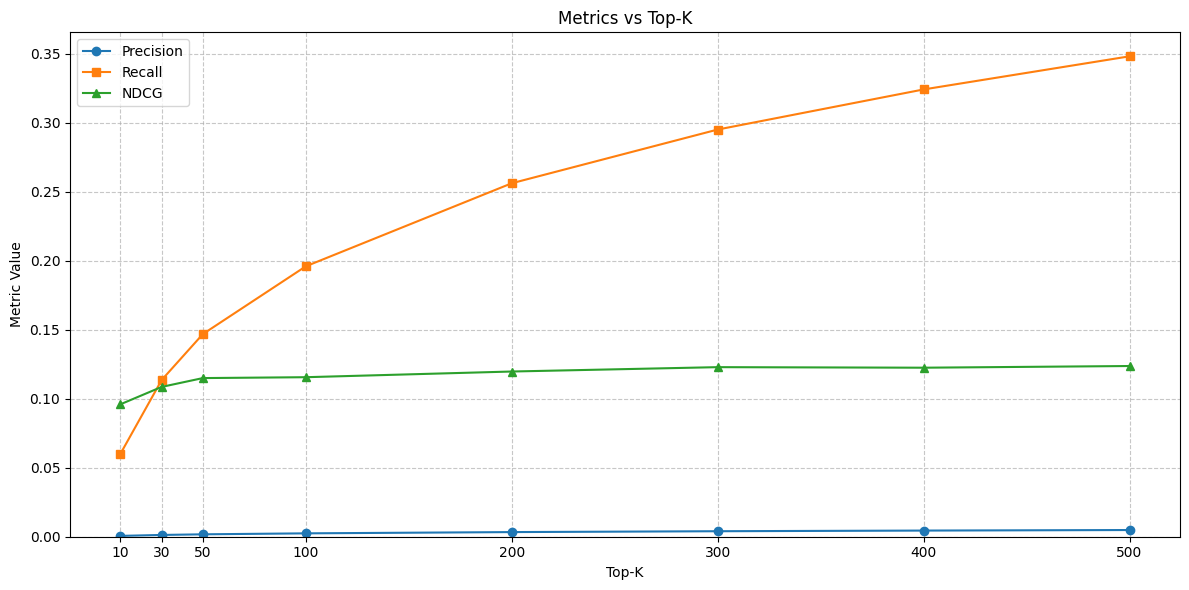

In [23]:
plt.figure(figsize=(12, 6))

plt.plot(topk_values, precisions, marker='o', label='Precision')
plt.plot(topk_values, recalls, marker='s', label='Recall')
plt.plot(topk_values, ndcgs, marker='^', label='NDCG')

plt.title('Metrics vs Top-K')
plt.xlabel('Top-K')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.xticks(topk_values)

plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

In [24]:
import random

random_user_id = random.choice(list(recommendations_dict.keys()))
print(random_user_id)

train_df[train_df['user_id'] == random_user_id]

514916579


,user_id,product_id,category_id,category_code,brand,user_index,product_index,brand_index,category_index
3727059,514916579,4800358,2053013554658804075,electronics.audio.headphone,plantronics,251676,1270,161,14
3728011,514916579,4800358,2053013554658804075,electronics.audio.headphone,plantronics,251676,1270,161,14
3728680,514916579,4801033,2053013554658804075,electronics.audio.headphone,plantronics,251676,1704,161,14
3729091,514916579,4802068,2053013554658804075,electronics.audio.headphone,plantronics,251676,5520,161,14
5430728,514916579,1002550,2053013555631882655,electronics.smartphone,blackberry,251676,3388,844,4
5431564,514916579,1004739,2053013555631882655,electronics.smartphone,xiaomi,251676,12,17,4
5433716,514916579,1005161,2053013555631882655,electronics.smartphone,xiaomi,251676,48,17,4
5435458,514916579,1005161,2053013555631882655,electronics.smartphone,xiaomi,251676,48,17,4
5436921,514916579,1004957,2053013555631882655,electronics.smartphone,xiaomi,251676,42,17,4
5440323,514916579,1004957,2053013555631882655,electronics.smartphone,xiaomi,251676,42,17,4


In [25]:
recommend_product_ids = recommendations_dict[random_user_id]
recommend_product_dict = train_df[train_df['product_id'].isin(recommend_product_ids)].groupby('product_id').apply(
    lambda x: tuple(x[['category_code']].iloc[0])
).to_dict()

for product_id in recommend_product_ids[:20]:
    category_code = recommend_product_dict[product_id]
    print(category_code)

('electronics.smartphone',)
('electronics.smartphone',)
('electronics.audio.headphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('#unknown',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.audio.headphone',)
('electronics.audio.headphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)
('electronics.smartphone',)


/var/folders/61/z_y23ln573b2r1g8y664sldc0000gn/T/ipykernel_10312/1566795865.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_product_dict = train_df[train_df['product_id'].isin(recommend_product_ids)].groupby('product_id').apply(
